# Model Inference

# Import Model

In [1]:
%run "Reusable_Functions.ipynb"

Using TensorFlow backend.


In [2]:
# Import data offline
db1 = import_DB('db4_5SS_full_s83552_1.npz')
db2 = import_DB('db4_5SS_full_s83552_2.npz')
db3 = import_DB('db4_5SS_full_s83552_3.npz')
db4 = import_DB('db4_5SS_full_s83552_4.npz')
db5 = import_DB('db4_5SS_full_s83552_5.npz')
y1=db1['out_motionData']
y2=db2['out_motionData']
y3=db3['out_motionData']
y4=db4['out_motionData']
y5=db5['out_motionData']

db1 = import_DB('db5_5SS_part_noisy_s83552_1.npz')
db2 = import_DB('db5_5SS_part_noisy_s83552_1.npz')
db3 = import_DB('db5_5SS_part_noisy_s83552_1.npz')
db4 = import_DB('db5_5SS_part_noisy_s83552_1.npz')
db5 = import_DB('db5_5SS_part_noisy_s83552_1.npz')
x1=db1['in_motionData']
x2=db2['in_motionData']
x3=db3['in_motionData']
x4=db4['in_motionData']
x5=db5['in_motionData']

cplr_noisy=np.concatenate((x1,x2,x3,x4,x5),axis=0)
cplr_true=np.concatenate((y1,y2,y3,y4,y5),axis=0)
print(cplr_noisy.shape)
print(cplr_true.shape)

(417760, 25, 8)
(417760, 25, 7)


In [4]:
def sampling(args):
    mu, log_var = args
    batch_size = K.shape(mu)[0]
    z_dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch_size, z_dim))
    return mu + K.exp(0.5 * log_var) * eps

def eucledian_norm(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true)))
def kl(z_mean,z_log_var):
    return 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis=-1)

def VAE_train(VAE, modelname):
    # VISUALIZING MODEL ARCHITECTURE
    VAE.summary()
    display(SVG(model_to_dot(VAE, show_shapes=True, show_layer_names=True, dpi=70).create(prog='dot', format='svg')))
    
    # TRAINING
    filepath=os.path.join('models_VAE', modelname+'.hdf5')
    #earlyStopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min', restore_best_weights=True)
    chkpt = ModelCheckpoint(filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
    train_data=VAE.fit([x_train], [y_train], shuffle=True, epochs=3000, batch_size=256, validation_data=([x_test], [y_test]), verbose=1, callbacks=[chkpt])
    
    # VISUALIZING LEARNING CURVES
    visualize_learning_curves(train_data)

def VAE_load(VAE, modelname):
    filepath=os.path.join('models_VAE', modelname+'.hdf5')
    #VAE=load_model(filepath, custom_objects={'rmse': rmse})
    VAE.load_weights(filepath)

def VAE_FC(hidden=[100,100,100], z_dim=30):
    inp=Input(shape=(25,8))
    encDim=hidden
    decDim=hidden[::-1]

    # Encoding
    x=Flatten()(inp)
    for i in encDim:
        x=Dense(i, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    x=Dense(decDim[0], activation='relu')(z)
    for i in decDim[1:]:
        x=Dense(i, activation='relu')(x)
    pos=Dense(75)(x)
    pos=Reshape((25, 3))(pos)
    orient=Dense(100)(x)
    orient=Reshape((25, 4))(orient)
    orient_norm=Lambda(lambda x: K.l2_normalize(x,axis=2))(orient)
    y=Concatenate(axis=2)([pos, orient_norm])
    
    # loss
    def reconstruction_loss(out_true, out_pred):
        return eucledian_norm(out_true, out_pred)
    def kl_loss(out_true, out_pred):
        return kl(z_mean,z_log_var)
    def vae_loss(out_true, out_pred):      
        return reconstruction_loss(out_true, out_pred) + kl_loss(out_true, out_pred)

    # build model
    vae = Model(inputs=[inp], outputs=[y])
    #vae.add_loss(vae_loss)
    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reconstruction_loss,kl_loss], )
    
    encoder = Model(inputs=[inp], outputs=[z_mean])
    return vae, encoder

In [5]:
# Load a VAE
VAE,_=VAE_FC([150,75],60)
modelname='VAE_FC_h2_z60'
VAE_load(VAE, modelname)
VAE.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 8)        0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 200)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 150)          30150       flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 75)           11325       dense_1[0][0]                    
____________________________________________________________________________________________

In [6]:
encoder=Model(VAE.input, VAE.layers[4].output)
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 8)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_2 (Dense)              (None, 75)                11325     
_________________________________________________________________
z_mean (Dense)               (None, 60)                4560      
Total params: 46,035
Trainable params: 46,035
Non-trainable params: 0
_________________________________________________________________


# Visualize VAE results

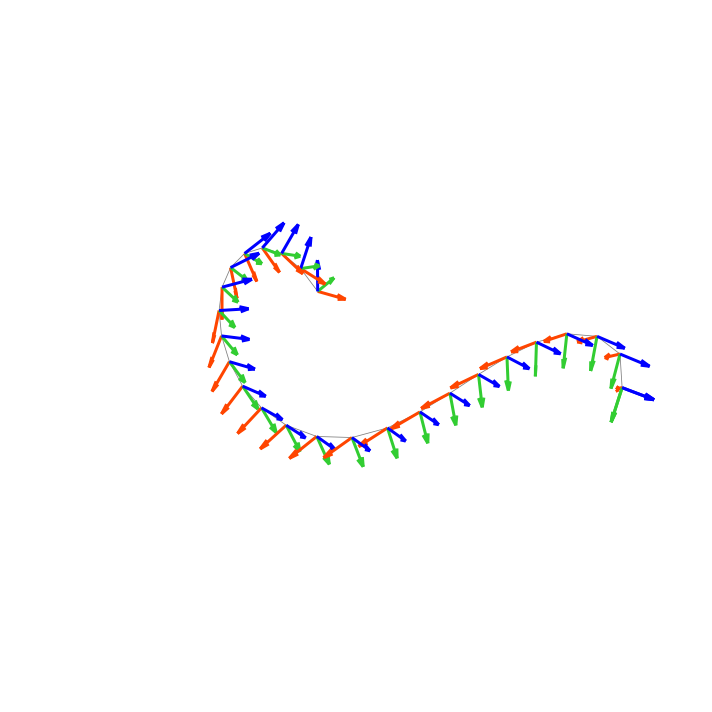

In [59]:
def plotXYZ(center, RotMat, ax, scale=1):
    C=np.vstack((center,center,center))
    R=scale*RotMat
    r='orangered'
    g='limegreen'
    b='blue'
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b),linewidth=3)
    plt.tight_layout()

index=249 #6,179, 249
fig = plt.figure(figsize=2.5*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotMotion(cplr_true[index][:,0:3], cplr_true[index][:,3:8], ax, .2, scale=.2)
plt.tight_layout()
ax.set_zticklabels([])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
from matplotlib.ticker import MultipleLocator
interval=.1
ax.xaxis.set_major_locator(MultipleLocator(interval))
ax.yaxis.set_major_locator(MultipleLocator(interval))
ax.zaxis.set_major_locator(MultipleLocator(interval))
#ax.grid(False)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
plt.axis('off')
plt.show()

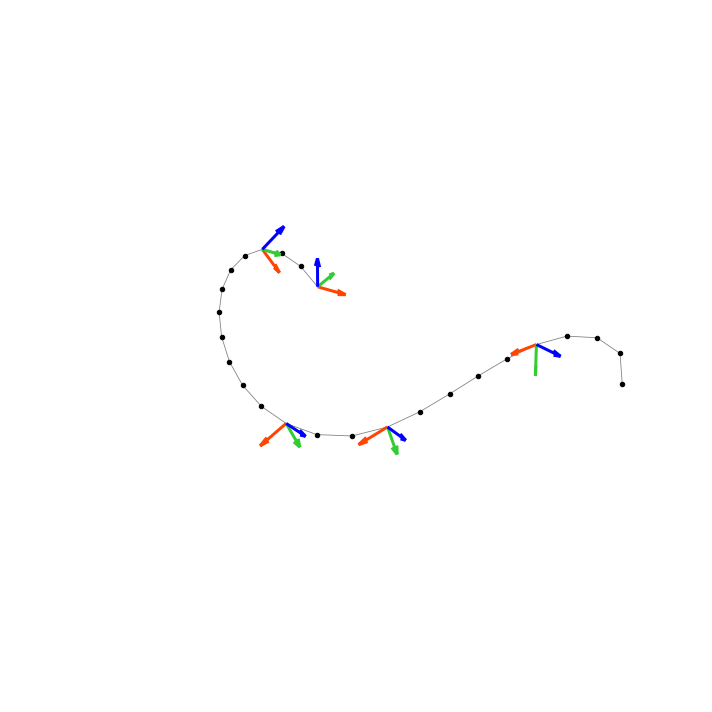

In [57]:
def plotMotionPartial(Pts, Orient, mask, ax, limit, color = 'gray', scale=.1):
    plotPath(Pts, ax, limit, color)
    for i in range(len(Pts)):
        if (mask[i]>.5):
            Rot_i=quat2rot(Orient[i])
            plotXYZ(Pts[i], Rot_i, ax, limit*scale)
        else:
            ax.scatter(Pts[i,0], Pts[i,1], Pts[i,2], color='k')
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])
    
    ax.set_xlabel('X', fontweight ='bold')
    ax.set_ylabel('Y', fontweight ='bold')
    ax.set_zlabel('Z', fontweight ='bold')
    plt.tight_layout()

index=249 #6,179, 249
mask_6=[1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1]
mask_179=[1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0]
mask_249=[1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0]
fig = plt.figure(figsize=2.5*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotMotionPartial(cplr_true[index][:,0:3], cplr_true[index][:,3:8],mask_249, ax, .2, scale=.2)
plt.tight_layout()
ax.set_zticklabels([])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
from matplotlib.ticker import MultipleLocator
interval=.1
ax.xaxis.set_major_locator(MultipleLocator(interval))
ax.yaxis.set_major_locator(MultipleLocator(interval))
ax.zaxis.set_major_locator(MultipleLocator(interval))
#ax.grid(False)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
plt.axis('off')
plt.show()

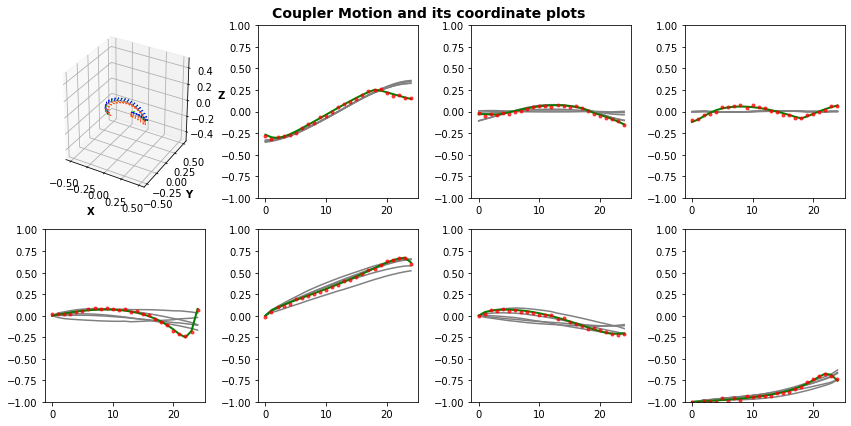

In [223]:
# Pure motion example
index=1
visualize_reconstructed_CplrMotion_VAE(cplr_noisy, cplr_true, VAE, n=index, n_reconst=5)

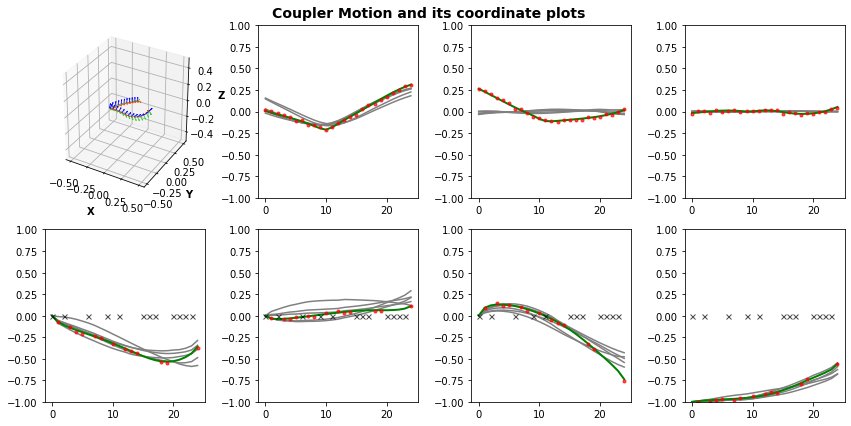

In [224]:
# Mixed motion and path example
index=62600
visualize_reconstructed_CplrMotion_VAE(cplr_noisy, cplr_true, VAE, n=index, n_reconst=5)

In [225]:
def maskOrient(inpdb,outdb,index,mask):
    inp=np.expand_dims(cplr_noisy[index].copy(),axis=0)
    out=np.expand_dims(cplr_true[index].copy(),axis=0)
    mask=np.expand_dims(mask,axis=1)
    inp[0,:,3:8]=np.multiply(inp[0,:,3:8],mask)
    return inp,out

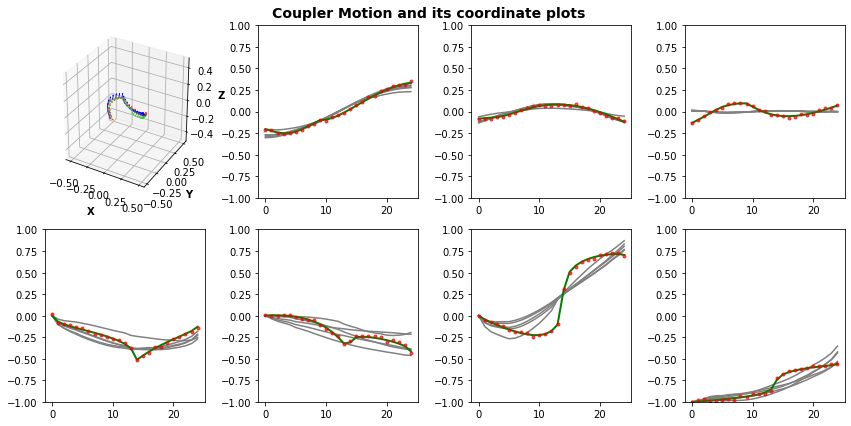

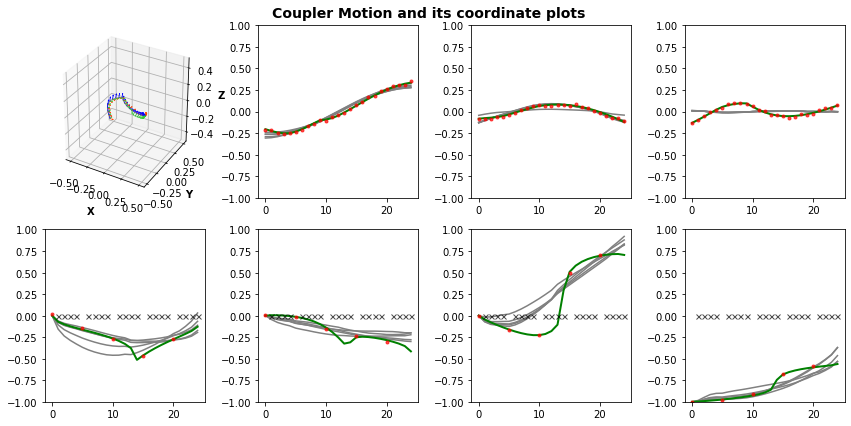

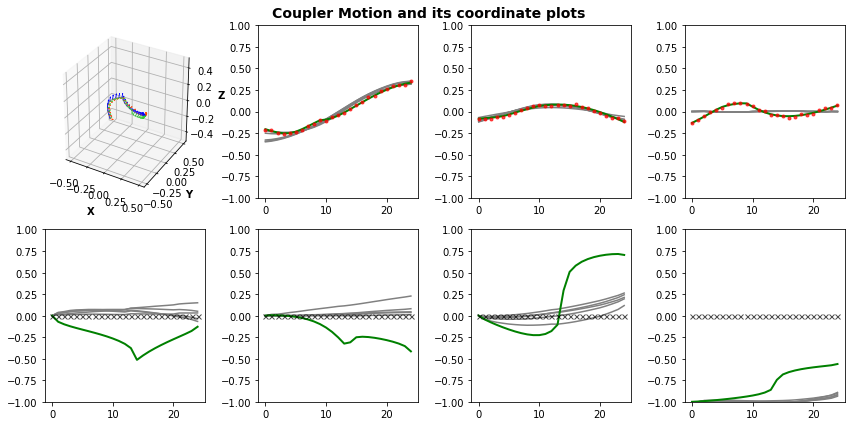

In [231]:
# Trying Mixed motion and path example
index=10000
visualize_reconstructed_CplrMotion_VAE(cplr_noisy, cplr_true, VAE, n=index, n_reconst=5)

inp,out=maskOrient(cplr_noisy,cplr_true,index,[1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0])
visualize_reconstructed_CplrMotion_VAE(inp, out, VAE, n=0, n_reconst=5)

inp,out=maskOrient(cplr_noisy,cplr_true,index,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
visualize_reconstructed_CplrMotion_VAE(inp, out, VAE, n=0, n_reconst=5)

# Cluster the z-space

We run the clustering algorithms on Z-space and divide the database in 500 clusters. This helps in quick query lookup when searching for solution mechanism.

In [13]:
# Find z-space representations 
z_param= encoder.predict(cplr_noisy)
print(z_param.shape)

(62664, 15)


In [14]:
z_param.dtype

dtype('float32')

In [ ]:
#Just crashes
#from sklearn.cluster import AgglomerativeClustering
#clustering = AgglomerativeClustering(n_clusters=500).fit(z_param)
#print(clustering.labels_.shape)

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=500)
kmeans.fit(z_param)
labels=kmeans.predict(z_param)
centers = kmeans.cluster_centers_

# Find solutions for input path

Random index selected =  22


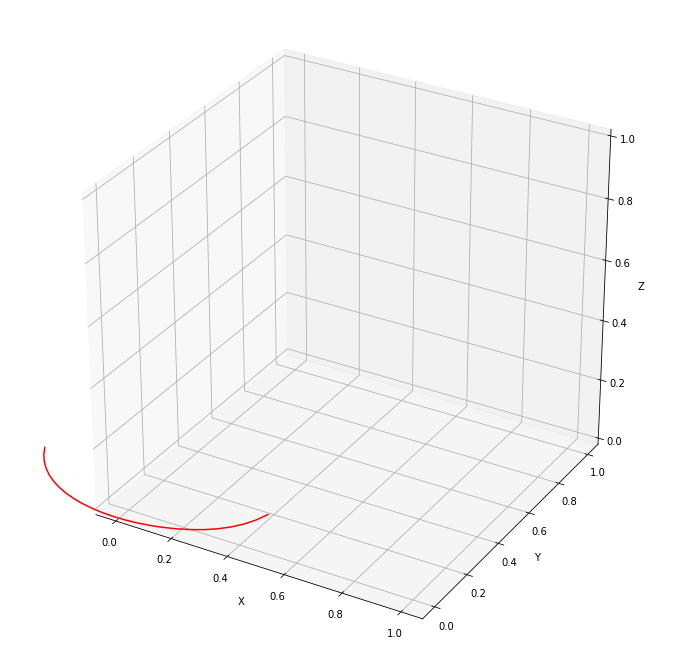

In [10]:
#Select an arbitrary path
n=random.randint(0, z_param.shape[0])
n=22 #22,49
print("Random index selected = ",n)
fig= plt.figure(figsize=(12, 12))
ax = plt.subplot(1, 1, 1, projection='3d')
plotPath3D(cplr_true[n], ax, 1,'r','X','Y','Z')

In [18]:
current_dir=os.getcwd()
db_path=os.path.join(current_dir,'..','1. DB Preprocessing','db4_5SS_mirror_s20084.npz')
db = np.load(db_path)
print(db.files)
mech=db['mechData']
print(mech.shape)
# Renormalize DB from range [-1,1] to range [0,1] 
n_mech=mech/(np.abs(data_min)+data_max)+np.abs(data_min)

['cplrData', 'mechData']
(20084, 11, 3)


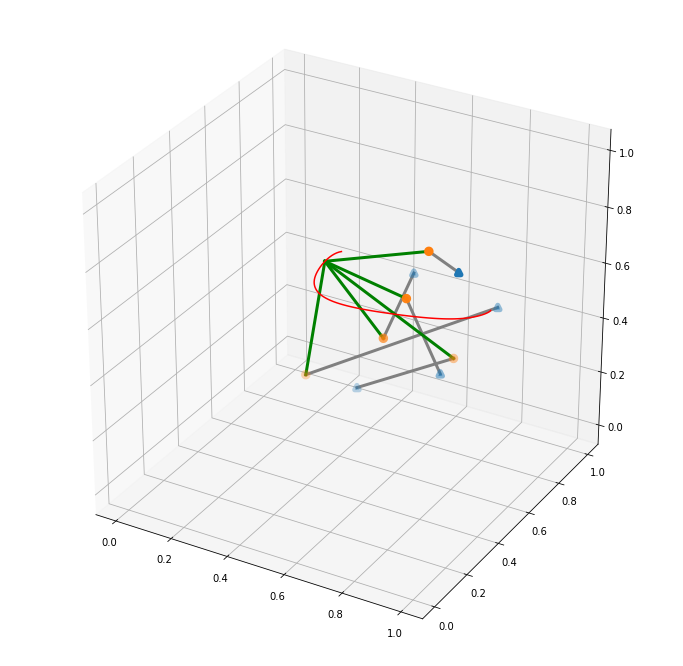

In [19]:
def plotLine3D(P1,P2,ax,color):
  ax.plot3D([P1[0],P2[0]], [P1[1],P2[1]], [P1[2],P2[2]],linewidth=3, color=color)

def plotMech5SS(mech,ax):
    Fp1=mech[0]; Fp2=mech[1];Fp3=mech[2]; Fp4=mech[3];Fp5=mech[4];
    Mp1=mech[5]; Mp2=mech[6];Mp3=mech[7]; Mp4=mech[8];Mp5=mech[9];
    C=mech[10];

    c1='grey'
    c2='g'
    plotLine3D(Fp1,Mp1,ax,c1)
    plotLine3D(Fp2,Mp2,ax,c1)
    plotLine3D(Fp3,Mp3,ax,c1)
    plotLine3D(Fp4,Mp4,ax,c1)
    plotLine3D(Fp5,Mp5,ax,c1)
    
    plotLine3D(Mp1,C,ax,c2)
    plotLine3D(Mp2,C,ax,c2)
    plotLine3D(Mp3,C,ax,c2)
    plotLine3D(Mp4,C,ax,c2)
    plotLine3D(Mp5,C,ax,c2)

    ax.scatter3D(mech[0:5,0],mech[0:5,1],mech[0:5,2],marker='^',linewidths=5)
    ax.scatter3D(mech[5:10,0],mech[5:10,1],mech[5:10,2],marker='o',linewidths=5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

i=7
fig= plt.figure(figsize=(12, 12))
ax = plt.subplot(1, 1, 1, projection='3d')
plotMech5SS(n_mech[i],ax)
plotPath3D(n_cplr_true[i], ax, 1,'r' )

47


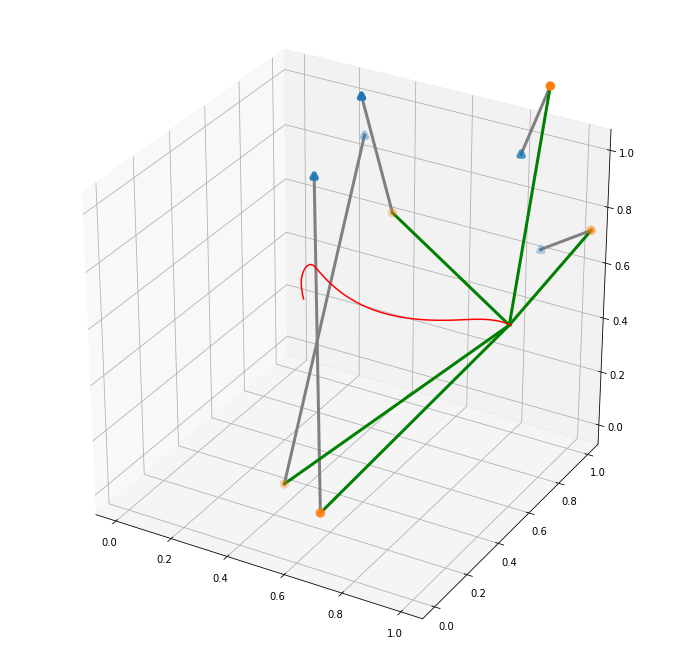

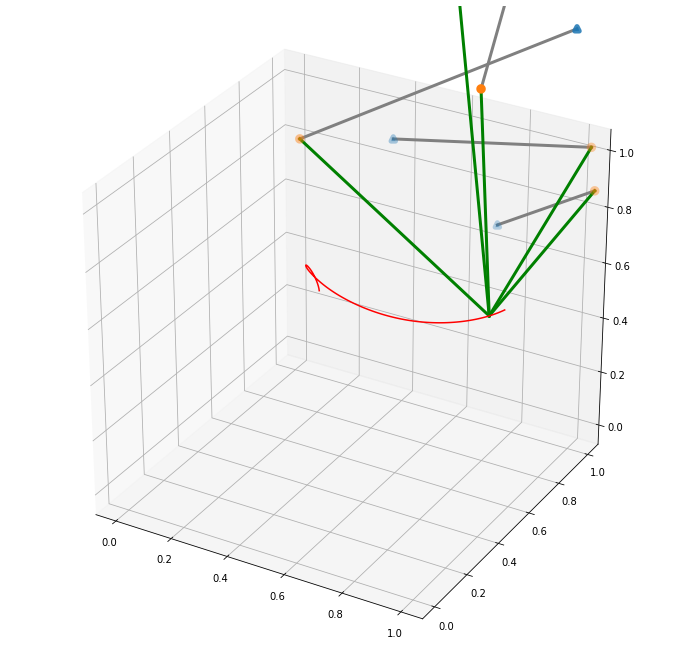

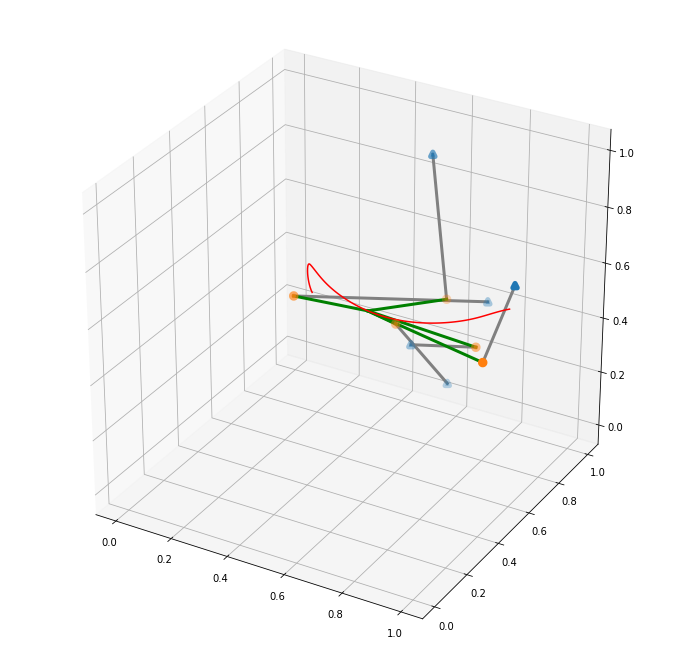

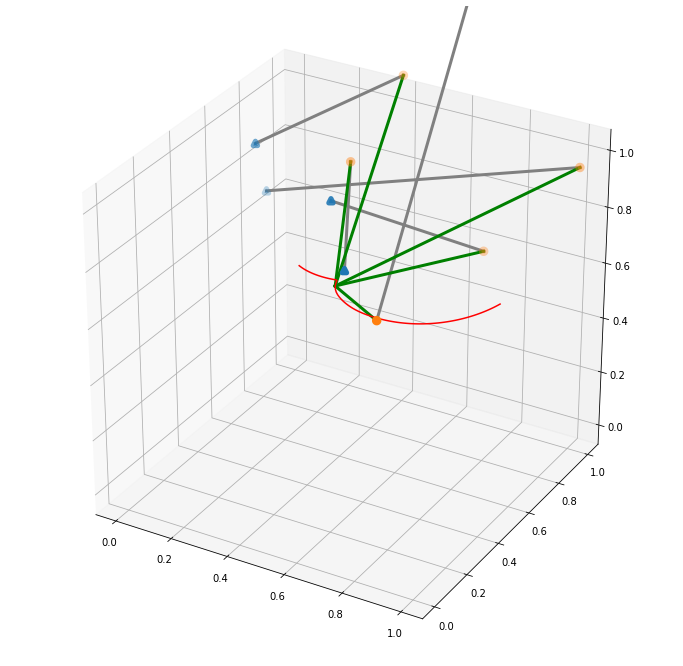

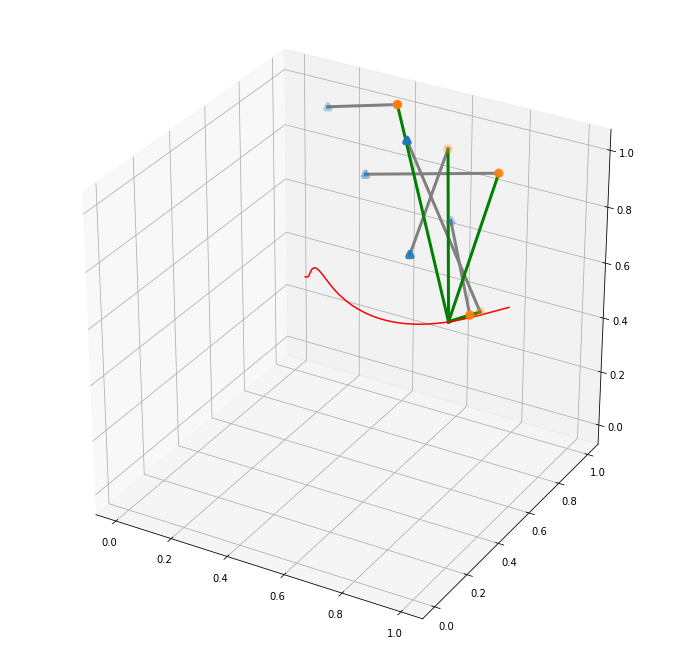

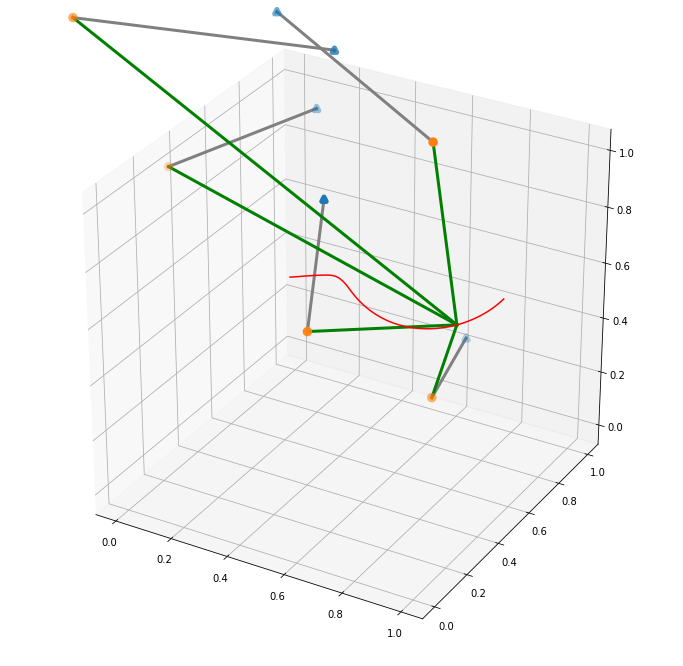

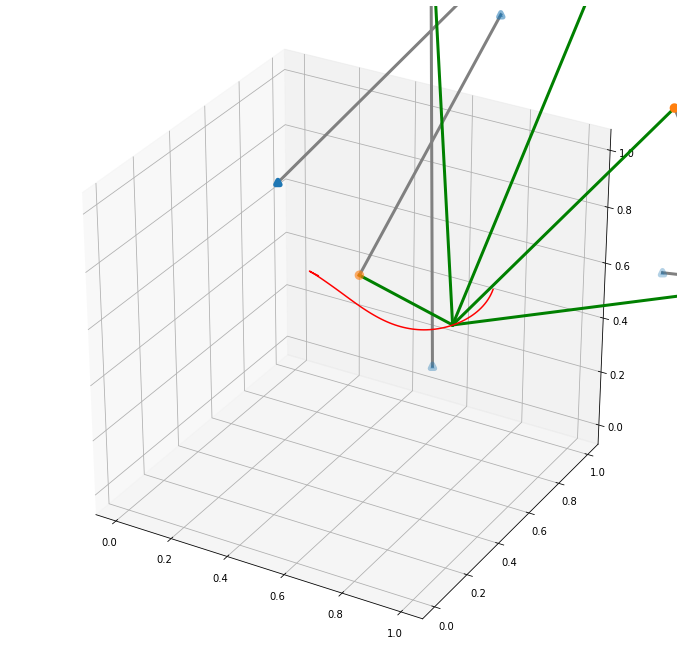

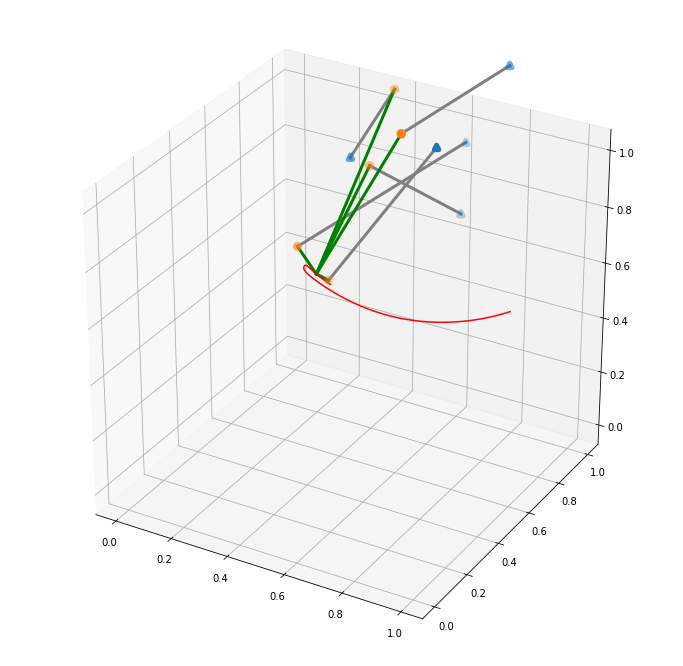

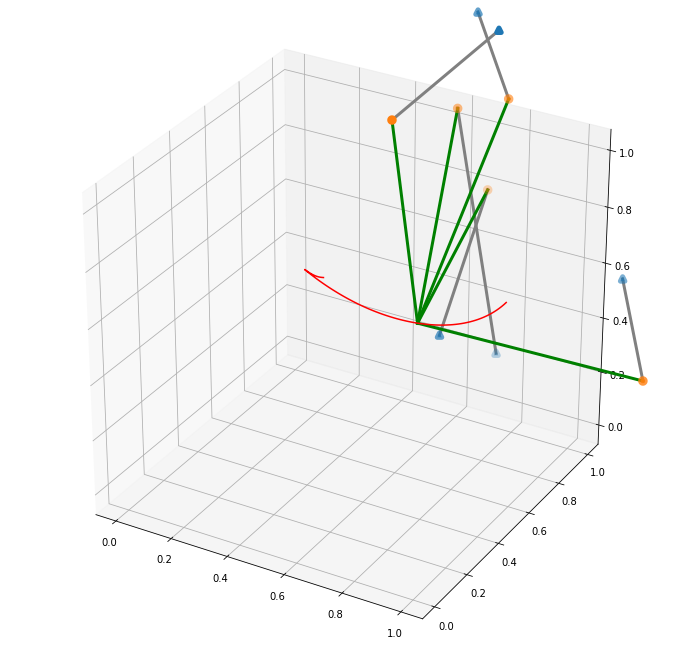

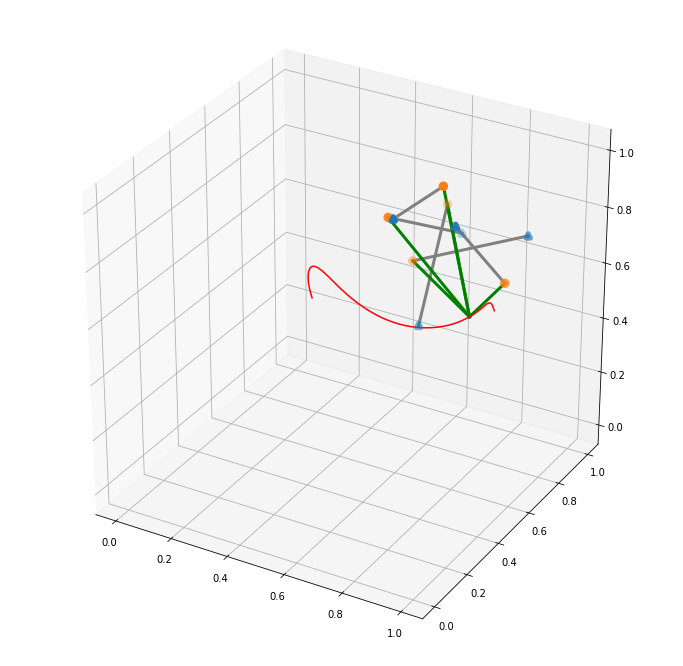

In [20]:
z_user=z_param[n]
minDist=99999999
group_id=-1
for i in range(500):
  d=np.linalg.norm(z_user-centers[i])
  if d<minDist:
    minDist=d
    group_id=i

sol=[]
for i in range(0,z_param.shape[0]):
  if labels[i]==group_id:
    sol.append(i)

for i in range(10):
    fig= plt.figure(figsize=(12, 12))
    ax = plt.subplot(1, 1, 1, projection='3d')
    plotMech5SS(n_mech[sol[i]],ax)
    plotPath3D(n_cplr_true[sol[i]], ax, 1,'r' )
    
print(len(sol))